<a href="https://colab.research.google.com/github/markomitos/proofie/blob/main/Fake_news_classification_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#Loading dataset

In [ ]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [ ]:
fake['label'] = 0
true['label'] = 1

In [ ]:
fake.drop(columns=["title", "date", "subject"], inplace=True)
true.drop(columns=["title", "date", "subject"], inplace=True)

In [ ]:
#Checking for null values
print(sum(fake["text"].isnull()))
print(sum(true["text"].isnull()))


0
0


In [ ]:
#Deleting duplicated rows if exist
fake.drop_duplicates(inplace=True)
true.drop_duplicates(inplace=True)

In [ ]:
print(sum(fake.duplicated()))
print(sum(true.duplicated()))
print(len(fake))
print(len(true))

0
0
17455
21192


In [ ]:
#Merging datasets
news=pd.concat([fake,true],ignore_index=True)

In [ ]:
print(len(news))
news.head(5)

38647


,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


#Preprocessing

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
#download and add words to ntlk data path
nltk.download('wordnet')
nltk.download('omw-1.4')
! unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/
! unzip /root/nltk_data/corpora/omw-1.4.zip -d /root/nltk_data/corpora/
nltk.data.path.append("/root/nltk_data/")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Archive:  /root/nltk_data/corpora/wordnet.zip
   creating: /root/nltk_data/corpora/wordnet/
  inflating: /root/nltk_data/corpora/wordnet/lexnames  
  inflating: /root/nltk_data/corpora/wordnet/data.verb  
  inflating: /root/nltk_data/corpora/wordnet/index.adv  
  inflating: /root/nltk_data/corpora/wordnet/adv.exc  
  inflating: /root/nltk_data/corpora/wordnet/index.verb  
  inflating: /root/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /root/nltk_data/corpora/wordnet/data.adj  
  inflating: /root/nltk_data/corpora/wordnet/index.adj  
  inflating: /root/nltk_data/corpora/wordnet/LICENSE  
  inflating: /root/nltk_data/corpora/wordnet/citation.bib  
  inflating: /root/nltk_data/corpora/wordnet/noun.exc  
  inflating: /root/nltk_data/corpora/wordnet/verb.exc  
  inflating: /root/nltk_data/corpora/wordnet/README  
  inflating: /root/nltk_data/corpora/wordnet/index.sense  
  inflating: /root/nltk_data/corpora/wordnet/data.noun  
  inflating: /root/nltk_data/corpora/wordnet/data.adv  


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Remove extra white space from text

    text = re.sub(r'\W', ' ', str(text)) # Remove all the special characters from text

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters from text

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove any character that isn't alphabetical

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [ ]:
#Seperate x and y
x = news.drop('label', axis=1)
y = news.label

In [ ]:
#apply preprocessing function to each text
texts=list(x['text'])
cleaned_texts = [process_text(text) for text in texts]
print(cleaned_texts[:10])

[['donald', 'trump', 'wish', 'american', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemy', 'hater', 'dishonest', 'fake', 'news', 'medium', 'former', 'reality', 'show', 'star', 'one', 'job', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'friend', 'supporter', 'even', 'healthy', 'president', 'angry', 'pant', 'tweeted', 'great', 'america', 'realdonaldtrump', 'december', 'tweet', 'went', 'welll', 'expect', 'kind', 'sends', 'greeting', 'like', 'despicable', 'petty', 'infantile', 'gibberish', 'lack', 'decency', 'allow', 'rise', 'gutter', 'long', 'enough', 'citizen', 'bishop', 'talbert', 'swan', 'talbertswan', 'calvin', 'calvinstowell', 'impeachment', 'would', 'make', 'also', 'accept', 'regaining', 'control', 'congress', 'miranda', 'yaver', 'mirandayaver', 'hear', 'talk', 'include', 'many', 'people', 'hate', 'wonder', 'alan', 'sandoval', 'alansandoval', 'us', 'word', 'marlene', 'say', 'koren', 'pollitt', 'korencarpenter', 'eve', 'including', 'fought', 'lost

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_texts)
sequences = tokenizer.texts_to_sequences(cleaned_texts)
padded_sequences = pad_sequences(sequences, maxlen=250, padding='post', truncating='post')

##Training

In [ ]:
#Got these from tensorflow site
#Tensorflow keeps the history of how we trained our model so that is why we can use these functions
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

Epoch 1/10
387/387 [==============================] - 45s 104ms/step - loss: 0.6897 - accuracy: 0.5443 - f1_score: 0.6925 - val_loss: 0.6851 - val_accuracy: 0.5503 - val_f1_score: 0.7074
Epoch 2/10
387/387 [==============================] - 26s 68ms/step - loss: 0.5567 - accuracy: 0.6818 - f1_score: 0.7792 - val_loss: 0.2311 - val_accuracy: 0.9339 - val_f1_score: 0.9422
Epoch 3/10
387/387 [==============================] - 20s 50ms/step - loss: 0.2193 - accuracy: 0.9352 - f1_score: 0.9434 - val_loss: 0.2033 - val_accuracy: 0.9416 - val_f1_score: 0.9484
Epoch 4/10
387/387 [==============================] - 15s 39ms/step - loss: 0.2063 - accuracy: 0.9423 - f1_score: 0.9486 - val_loss: 0.2052 - val_accuracy: 0.9550 - val_f1_score: 0.9578
Epoch 5/10
387/387 [==============================] - 12s 32ms/step - loss: 0.1700 - accuracy: 0.9578 - f1_score: 0.9603 - val_loss: 0.1959 - val_accuracy: 0.9507 - val_f1_score: 0.9559
Epoch 6/10
387/387 [==============================] - 13s 34ms/step -

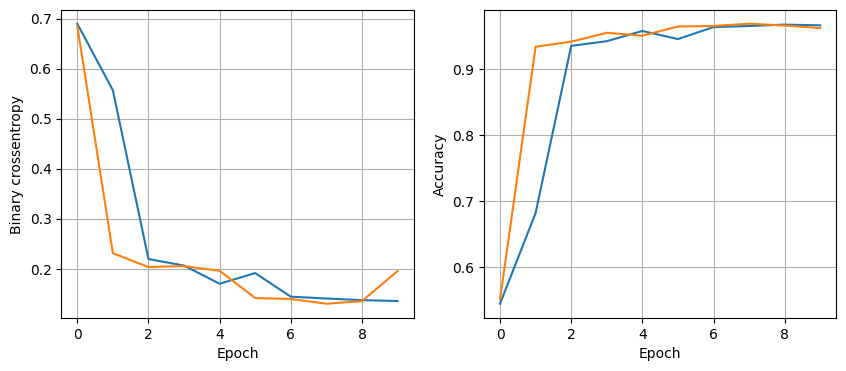

In [ ]:
from sklearn.model_selection import train_test_split

import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=250),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy',f1_score])



history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


test_loss, test_acc, test_f1 = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('F1 score:', test_acc)

plot_history(history)

#Huggingface model

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(news, test_size=0.2, random_state=42)

In [ ]:
train_fake_news = train[train['label'] == 0]
train_true_news = train[train['label'] == 1]

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics.pairwise import cosine_similarity

# Koristimo prethodno obučeni model za kreiranje embeddinga
model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = model(inputs)
    # Koristimo srednju vrednost svih token embeddinga kao embedding za ceo tekst
    sentence_embedding = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    return sentence_embedding.numpy()

def get_embeddings(texts):
    embeddings = []
    for text in texts:
        embedding = get_embedding(text)
        embeddings.append(embedding)
    # Vraćamo srednju vrednost svih embeddinga
    return np.mean(embeddings, axis=0)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
fake_news_embedding = get_embeddings(train_fake_news["text"][:5000])
true_news_embedding = get_embeddings(train_true_news["text"][:5000])

In [ ]:
# Izračunavamo kosinusnu sličnost između vesti i embeddinga
def is_true_news(news_text):
    news_embedding = get_embedding(news_text)
    similarity_with_fake = cosine_similarity(news_embedding, fake_news_embedding)
    similarity_with_true = cosine_similarity(news_embedding, true_news_embedding)
    # Biramo tu slicnost koja je bliza
    return 0 if similarity_with_fake > similarity_with_true else 1


def predict(news_dataset):
  n = len(news_dataset)
  correct_predictions = 0
  for index, news in news_dataset.iterrows():
    pred = is_true_news(news[0])  # news[0] is the text of the news article
    if pred == news[1]:  # news[1] is the label
       correct_predictions += 1
  accuracy = correct_predictions / n
  print(f'Accuracy: {accuracy * 100}%')



In [ ]:
predict(test[3000:5000])



Accuracy: 91.5%
